# Modeling and Evaluation

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Mildew-Image-Detector/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Mildew-Image-Detector'

### Set Inputs

In [4]:
my_data_dir = 'inputs/datasets/raw/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set Outputs

In [5]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


### Set Labels

In [6]:
labels = os.listdir(train_path)
print( f"Project Labels: {labels}")

Project Labels: ['healthy', 'powdery_mildew']


### Set Image Shape

In [10]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

## Review number of images in sets

From the code below we get a nice visualization of the spread and quantity of images available to us in our data set.
We have a healthy ammount to train a model for our needs, but will still need to randomize these images a bit more to properly train the AI later on.

/tmp/ipykernel_1874/2172016582.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_freq = df_freq.append(
/tmp/ipykernel_1874/2172016582.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_freq = df_freq.append(
/tmp/ipykernel_1874/2172016582.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_freq = df_freq.append(
/tmp/ipykernel_1874/2172016582.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_freq = df_freq.append(
/tmp/ipykernel_1874/2172016582.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_freq = df_freq.append(
/tmp/

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




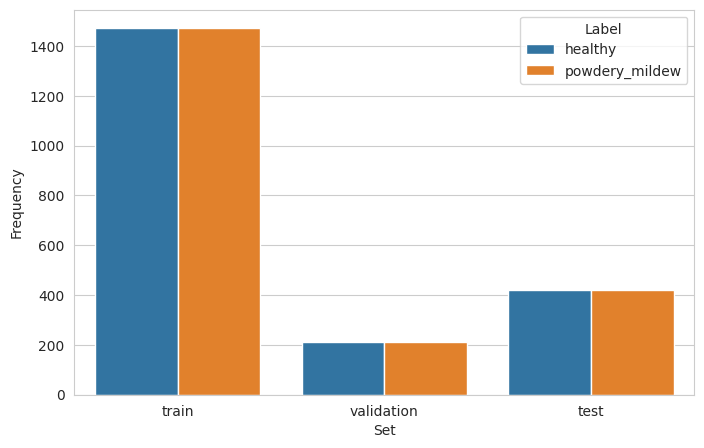

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Image Augmentation

This function generates batches of image data with real-time data augmentation.

In this project, we are artificially creating more training images with a combination of
multiple processes like 
* a random rotation of 20 degrees
* shifting the width of images by 0.10 ratio of the image
* shifting the height of the images by 0.10 ratio of the images 
* shearing the image by 0.1
* zooming the image by 10 percent
* flipping the image horizontally and vertically
* filling the broken pixels of the images with the nearest pixel value
* and standardizing the image pixels between 0 to 255 pixels.

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmented_image_data = ImageDataGenerator(rotation_range=20,
                                        width_shift_range=0.10,
                                        height_shift_range=0.10,
                                        shear_range=0.1,
                                        zoom_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='nearest',
                                        rescale=1./255
                                        )

We will apply augmented_image_data which we have initialized over the training, validation and testing sets
using flow_from_directory function to fetch images directly from the training folder.

We transform each image in width and height of average image_shape variable, Standard RGB
mode, batch_size of 20 images, binary class mode as we have two classes
of cell images, and we’ll also randomly shuffle the images.

In [15]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=True
                                                    )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

We are also fetching images from the validation and test folders and
using the same function flow_from_directory on them but only for the image standardizing.

We are also only standardizing image pixels between 0 to 255 pixels using ImageDataGenerator for these two sets because  
we first need to build up our data set with large numbers of images of different scenarios so that we can train
our model which we will get from the training sets.

We’ll then use the Test and Validation datasets to simply test if our model is working.

In [16]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [17]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                target_size=image_shape[:2],
                                                                color_mode='rgb',
                                                                batch_size=batch_size,
                                                                class_mode='binary',
                                                                shuffle=False
                                                                )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Let's take a look at how these changes have effected some of the images in the train set.

(20, 256, 256, 3)


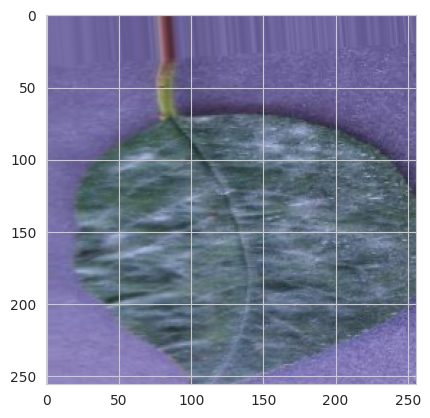

(20, 256, 256, 3)


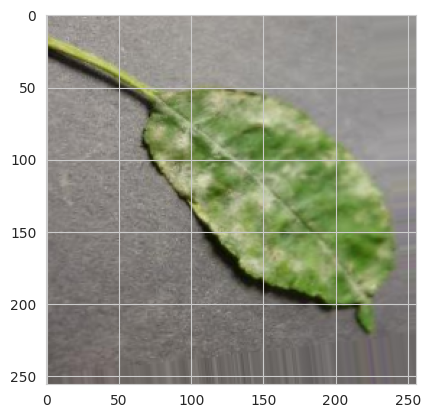

(20, 256, 256, 3)


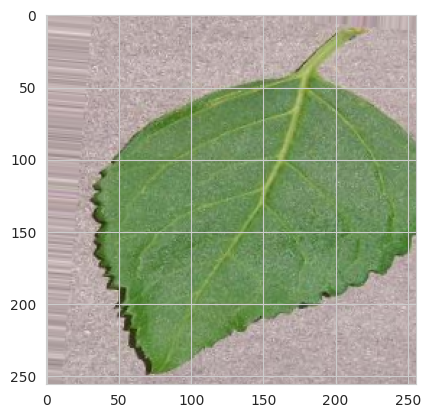

In [18]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

And for the validation and test images
we see the images are not rotated or sheared but only the pixels have
been standardized between 0 to 255 pixels. 

So now, the images are augmented and
are ready to be used for developing and training a CNN model.

(20, 256, 256, 3)


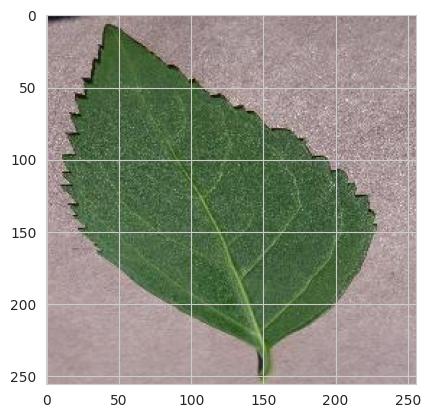

(20, 256, 256, 3)


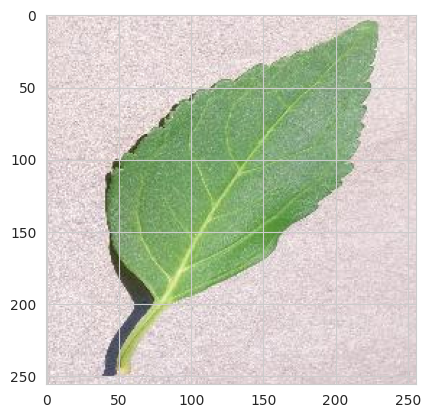

(20, 256, 256, 3)


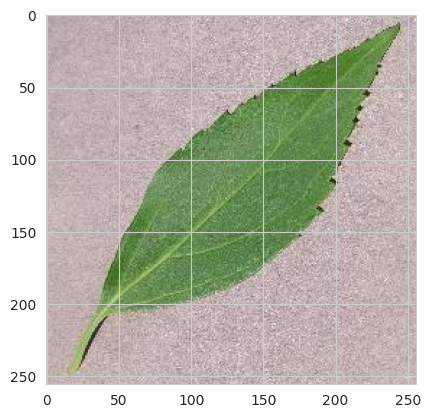

(20, 256, 256, 3)


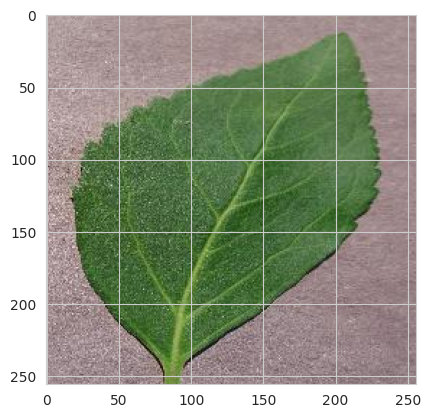

(20, 256, 256, 3)


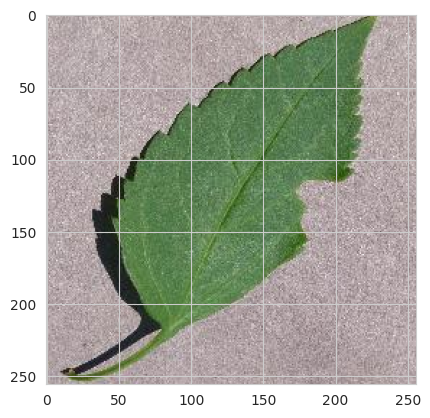

(20, 256, 256, 3)


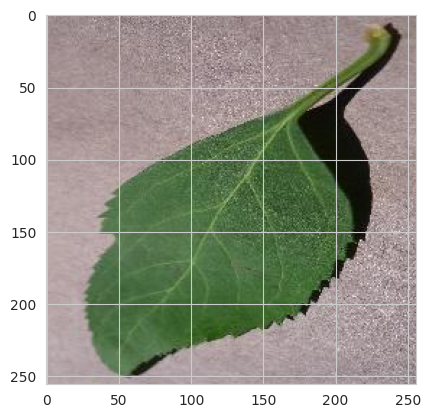

In [21]:
# Plot augmented validation and test images

for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()